In [1]:
#from math import sin, cos, tan
#from cmath import exp
import numpy as np
from Numpy_functions import *
from Torch_functions import *
import pandas as pd
import matplotlib.pyplot as plt
import copy
from IPython.display import clear_output
%matplotlib inline

# Data Generation

In [42]:
N_layers=4
d_max=350
n1=1.45
n2=2.08
training_structure=np.zeros((N_layers+2,2),dtype=float)
d=np.random.randint(0,high=d_max,size=N_layers+1)

for i in range(1,N_layers+1,2):
    training_structure[i,0]=n1
    training_structure[i,1]=d[i-1]
    training_structure[i+1,0]=n2
    training_structure[i+1,1]=d[i]
training_structure[0,0]=1
training_structure[N_layers+1,0]=1.52
training_structure[0,1]=training_structure[N_layers+1,1]=0
#training_structure=training_structure[::-1]
#training_structure[0,0]=1.52
#training_structure[N_layers+1,0]=1

In [3]:
print(training_structure)

[[  1.     0.  ]
 [  1.45 235.  ]
 [  2.08  75.  ]
 [  1.52   0.  ]]


In [43]:
n_samples=10000
wavelength_min=400
wavelength_max=800
points=100
thicknes=np.random.randint(0,high=d_max,size=(n_samples,N_layers))

Sample_n_per_cycle=36000
sample_numbers=np.arange(0,stop=n_samples, step=Sample_n_per_cycle)

N_all_wl=numpy_N_fixed_angle(training_structure[:,0])
t_wl=numpy_create_tm_fixed_angle(N_all_wl)

wavelengths=np.linspace(wavelength_min,wavelength_max,points)
wavevector=2*np.pi/wavelengths
training_type="real+imag"
#training_type="abs"
if training_type=="real+imag":
    refl=np.zeros((n_samples,2*points),dtype=float)
    for number in sample_numbers:
        print(number)
        phase=numpy_phase_all_wavelengths(thicknes[number:number+Sample_n_per_cycle],N_all_wl,wavevector)
        total_matrix=numpy_R_for_all_wavelengths(phase,t_wl)
        refl[number:number+Sample_n_per_cycle,:points]=np.real(total_matrix)
        refl[number:number+Sample_n_per_cycle,points:]=np.imag(total_matrix)
else:
    refl=np.zeros((n_samples,points),dtype=float)
    for number in sample_numbers:
        print(number)
        phase=numpy_phase_all_wavelengths(thicknes[number:number+Sample_n_per_cycle],N_all_wl,wavevector)
        total_matrix=numpy_R_for_all_wavelengths(phase,t_wl)
        refl[number:number+Sample_n_per_cycle]=np.abs(total_matrix)

0


In [44]:
n_samples=10000

thicknes_test=np.random.randint(0,high=d_max,size=(n_samples,N_layers))

Sample_n_per_cycle=24000
sample_numbers=np.arange(0,stop=n_samples, step=Sample_n_per_cycle)
if training_type=="real+imag":
    refl_test=np.zeros((n_samples,2*points),dtype=float)
    for number in sample_numbers:
        print(number)
        phase=numpy_phase_all_wavelengths(thicknes_test[number:number+Sample_n_per_cycle],N_all_wl,wavevector)
        total_matrix=numpy_R_for_all_wavelengths(phase,t_wl)
        refl_test[number:number+Sample_n_per_cycle,:points]=np.real(total_matrix)
        refl_test[number:number+Sample_n_per_cycle,points:]=np.imag(total_matrix)
else:
    refl_test=np.zeros((n_samples,points),dtype=float)
    for number in sample_numbers:
        print(number)
        phase=numpy_phase_all_wavelengths(thicknes_test[number:number+Sample_n_per_cycle],N_all_wl,wavevector)
        total_matrix=numpy_R_for_all_wavelengths(phase,t_wl)
        refl_test[number:number+Sample_n_per_cycle]=np.abs(total_matrix)

0


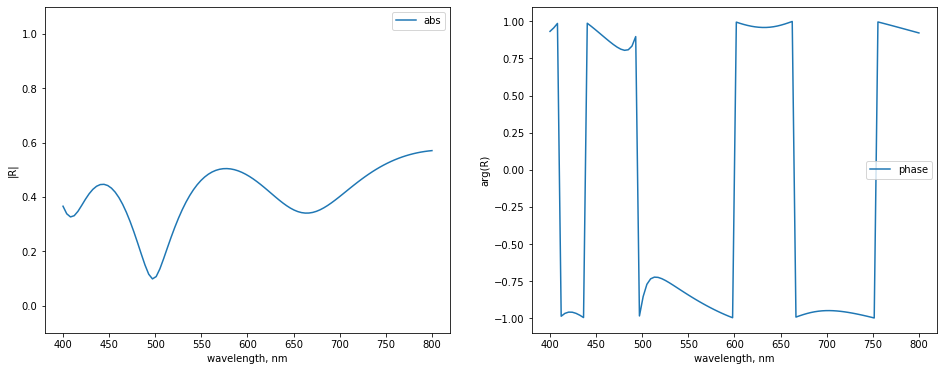

In [45]:
number=0
fig=plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(wavelengths, np.sqrt(refl[number,:points]**2+refl[number,points:]**2), label="abs")
plt.xlabel("wavelength, nm")
plt.ylabel("|R|")
plt.ylim(top=1.1, bottom=-0.1)
plt.legend()
plt.subplot(1,2,2)
plt.plot(wavelengths, np.arctan2(refl[number,points:],refl[number,:points])/np.pi, label="phase")
plt.xlabel("wavelength, nm")
plt.ylabel("arg(R)")
plt.legend()
plt.show()

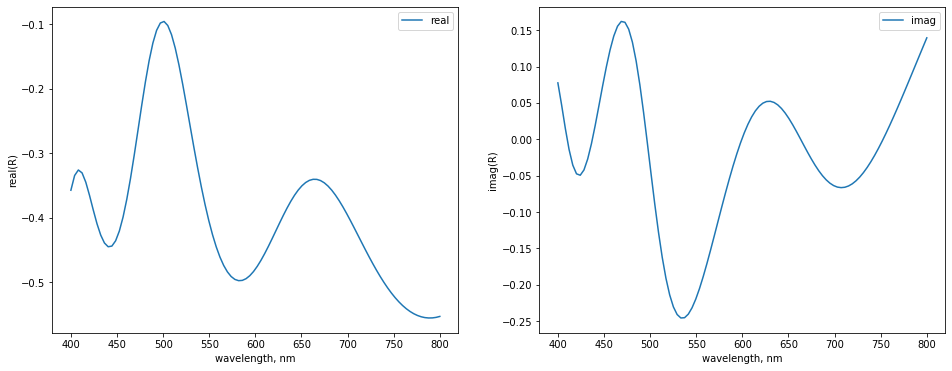

In [46]:
number=0
fig=plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(wavelengths, refl[number,:points], label="real")
plt.xlabel("wavelength, nm")
plt.ylabel("real(R)")

plt.legend()
plt.subplot(1,2,2)
plt.plot(wavelengths, refl[number,points:], label="imag")
plt.xlabel("wavelength, nm")
plt.ylabel("imag(R)")
plt.legend()
plt.show()

# Data load

In [3]:
file_name='10layers_angle'
train_structures=np.loadtxt('train/train_thicknes_'+file_name+'.csv',delimiter=',',dtype=float)
refl_train_pd=pd.read_csv('train/train_R_'+file_name+'.csv',delimiter=',',header=None,skiprows=6)
refl_train=refl_train_pd.to_numpy()


In [4]:
N_layers=train_structures.shape[1]

In [6]:
test_structures=np.loadtxt('test/test_thicknes_'+file_name+'.csv',delimiter=',',dtype=float)
refl_test_pd=pd.read_csv('test/test_R_'+file_name+'.csv',delimiter=',',header=None,skiprows=6)
refl_test=refl_test_pd.to_numpy()

In [17]:
with open('train/train_thicknes_'+file_name+'.csv') as f:
    f.readline()
    structure=f.readline()
    max_thick_nm=f.readline()
n_structure=np.fromstring(structure[4:-3], dtype=float, sep=' ')
d_max=int(max_thick_nm[-5:])
with open('train/train_R_'+file_name+'.csv') as f:
    f.readline()
    f.readline()
    ang_str=f.readline()
    wl=int(f.readline()[18:21])
    points_str=f.readline()
angle_min=int(ang_str[17:-7])
angle_max=int(ang_str[21:-2])
points=int(points_str[20:-1])
print(f"Array of layer indices:\n {n_structure} \n Maximal thickness of layer: {d_max} nm\n \
Angle range: {angle_min} - {angle_max}\n Wavelength: {wl} nm\n Number of discretezation points: {points}")
angles=np.linspace(angle_min, angle_max, points)
wavevector=2*np.pi/wl

Array of layer indices:
 [1.   1.45 2.08 1.45 2.08 1.45 2.08 1.45 2.08 1.45 2.08 1.52] 
 Maximal thickness of layer: 350 nm
 Angle range: 0 - 40
 Wavelength: 800 nm
 Number of discretezation points: 100


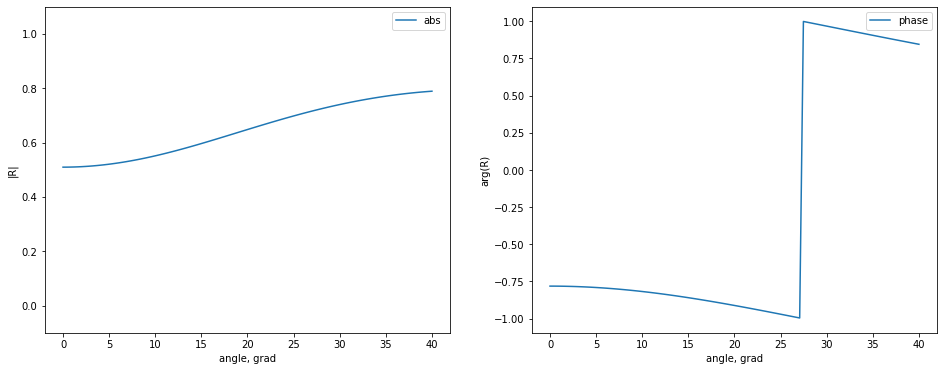

In [18]:
number=0
fig=plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(angles, np.sqrt(refl_train[number,:points]**2+refl_train[number,points:]**2), label="abs")
plt.xlabel("angle, grad")
plt.ylabel("|R|")
plt.ylim(top=1.1, bottom=-0.1)
plt.legend()
plt.subplot(1,2,2)
plt.plot(angles, np.arctan2(refl_train[number,points:],refl_train[number,:points])/np.pi, label="phase")
plt.xlabel("angle, grad")
plt.ylabel("arg(R)")
plt.legend()
plt.show()

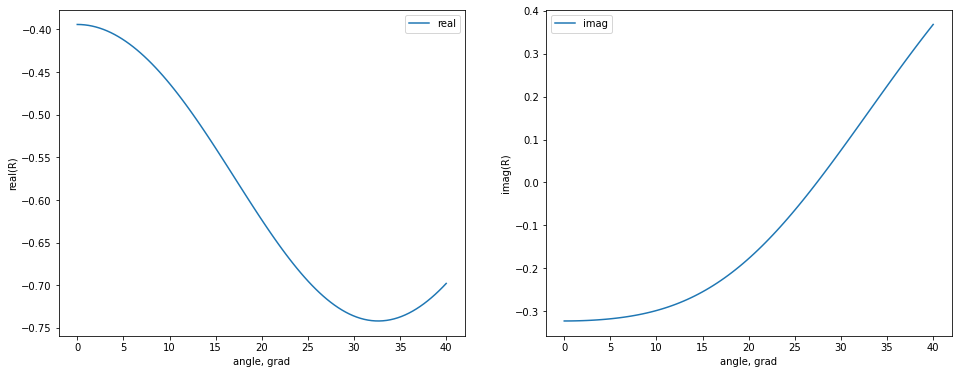

In [19]:
number=0
fig=plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(angles, refl_train[number,:points], label="real")
plt.xlabel("angle, grad")
plt.ylabel("real(R)")

plt.legend()
plt.subplot(1,2,2)
plt.plot(angles, refl_train[number,points:], label="imag")
plt.xlabel("angle, grad")
plt.ylabel("imag(R)")
plt.legend()
plt.show()

# Torch inizialization

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset

In [21]:
torch.manual_seed(19)

In [22]:
class Back_Net(nn.Module):
    
    def __init__(self, inputs, outputs, hidden_layers):
        super(Back_Net, self).__init__()
        current_dim = inputs
        self.layers = nn.ModuleList()
        for hdim in hidden_layers:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, outputs))
        
    def forward(self,x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return torch.sigmoid(self.layers[-1](x))
    
    def weight_init(self,init_type='kaiming uniform'):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if init_type=='kaiming uniform':
                    torch.nn.init.kaiming_uniform_(layer.weight.data,nonlinearity='relu')
                    torch.nn.init.zeros_(layer.bias.data)
                elif init_type=='kaiming normal':
                    torch.nn.init.kaiming_normal_(layer.weight.data,nonlinearity='relu')
                    torch.nn.init.zeros_(layer.bias.data)
                elif init_type=='xavier normal':
                    torch.nn.init.xavier_normal_(layer.weight.data)
                    torch.nn.init.zeros_(layer.bias.data)
                elif init_type=='xavier uniform':
                    torch.nn.init.xavier_uniform_(layer.weight.data)
                    torch.nn.init.zeros_(layer.bias.data)

In [23]:
Spectrum_train=torch.FloatTensor(refl_train[:1000])
train_dataset=TensorDataset(Spectrum_train)

Spectrum_test=torch.FloatTensor(refl_test[:500])
test_dataset=TensorDataset(Spectrum_test)

#train_amount=2000
#train_dataset,test_dataset=torch.utils.data.random_split(TensorDataset(torch.FloatTensor(refl)),
                                                         #[train_amount,len(refl)-train_amount])
print(Spectrum_train.shape, Spectrum_test.shape)

torch.Size([1000, 200]) torch.Size([500, 200])


In [24]:
def train(model, device, epochs, train_dataset, test_dataset, batch_size, points=20):
    
    model = model.to(device)
    train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader=torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
    loss=nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)
    
    train_loss_history=[]
    test_loss_history=[]

    best_result = 100.0
    
    N_all=create_N_for_all_angles(n_structure,wl=wl, angle_start=angle_min, angle_stop=angle_max,points=points)
    #N_all=create_N_for_fixed_angle(n_structure)
    transfer=create_transfer_matrix_all_angles(N_all)
    #transfer=create_transfer_matrix_fixed_angle(N_all,device)
    N=torch.tensor(np.real(N_all),device=device)
    
    for epoch_index in range(1,epochs):
    
        train_error=0
        model.train()
    
        for X_batch in train_dataloader:
            optimizer.zero_grad()
            X_batch = X_batch[0].to(device)
            y_pred = model.forward(X_batch)
            #loss_val = loss(R_Spectrum_for_batch(y_pred*d_max,N,transfer,wavevectors_pt, points,device), X_batch)
            #loss_val = loss(abs_R_Spectrum_for_batch(y_pred*d_max,N,transfer, wavevectors_pt, points=points), X_batch)
            loss_val = loss(R_for_batch(y_pred*d_max,N,transfer, points=points), X_batch)
            #loss_val = loss(abs_R_for_batch(y_pred*d_max,N,transfer, points=points), X_batch)
            train_error+=loss_val
        
            loss_val.backward()
            optimizer.step()
        
        scheduler.step()
                
        train_loss_history.append(train_error/len(train_dataloader))
        
        with torch.no_grad():
            model.eval()
            test_error=0
            for X_batch_test in test_dataloader:
                X_batch_test = X_batch_test[0].to(device)
                test_preds = model.forward(X_batch_test)
                #test_error+=loss(R_Spectrum_for_batch(test_preds*d_max,N,transfer, wavevectors_pt, points,device), X_batch_test)
                #test_error+=loss(abs_R_Spectrum_for_batch(test_preds*d_max,N,transfer, wavevectors_pt, points=points), X_batch_test)
                test_error+=loss(R_for_batch(test_preds*d_max,N,transfer, wl=780, points=points), X_batch_test)
                #test_error+=loss(abs_R_for_batch(test_preds*d_max,N,transfer, wl=780, points=points), X_batch_test)
            epoch_result=test_error/len(test_dataloader)
            test_loss_history.append(test_error/len(test_dataloader))
    
        
        if epoch_result < best_result:
            best_result = epoch_result
            torch.save(model, "inverse_model.pth")
        if epoch_index % 10 == 0:
            #print("Epoch number:",epoch_index,"Validation loss:",epoch_result.item(), "Training error: ", train_loss_history[-1])
            print("Epoch number:{} Validation loss: {:.7f}, Training error: {:.7f}".format(epoch_index, epoch_result.item(),train_loss_history[-1]))
        
    model=torch.load("inverse_model.pth")
    return model,train_loss_history,test_loss_history

In [13]:
Backward_model=Back_Net(2*points,N_layers,[50,100,100,100,100,50])
print(Backward_model)

Back_Net(
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=3, bias=True)
  )
)


# Var neurons number

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

epochs=250
batch_size=10000

print("Starting model with 50 neurons")
model_50=Back_Net(2*points,N_layers,[50,100,100,100,50])
model_50, train_50, test_50 =train(model_50, device, epochs, train_dataset, test_dataset, batch_size, points)

print("Starting model with 150 neurons")
model_150=Back_Net(2*points,N_layers,[50,100,100,100,150])
model_150, train_150, test_150 =train(model_150, device, epochs, train_dataset, test_dataset, batch_size, points)

print("Starting model with 100 neurons")
model_100=Back_Net(2*points,N_layers,[50,100,100,100,100])
model_100, train_100, test_100 =train(model_100, device, epochs, train_dataset, test_dataset, batch_size, points)

print("Starting model with 200 neurons")
model_200=Back_Net(2*points,N_layers,[50,100,100,100,200])
model_200, train_200, test_200 =train(model_200, device, epochs, train_dataset, test_dataset, batch_size, points)


Starting model with 50 neurons


C:\Users\user\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Back_Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\user\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\user\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch number:10 Validation loss: 0.1161522, Training error: 0.1190416
Epoch number:20 Validation loss: 0.0481340, Training error: 0.0490042
Epoch number:30 Validation loss: 0.0304665, Training error: 0.0314386
Epoch number:40 Validation loss: 0.0178400, Training error: 0.0183885
Epoch number:50 Validation loss: 0.0132960, Training error: 0.0136052
Epoch number:60 Validation loss: 0.0109595, Training error: 0.0111186
Epoch number:70 Validation loss: 0.0095351, Training error: 0.0096585
Epoch number:80 Validation loss: 0.0082897, Training error: 0.0083838
Epoch number:90 Validation loss: 0.0073309, Training error: 0.0073844
Epoch number:100 Validation loss: 0.0069477, Training error: 0.0069827
Epoch number:110 Validation loss: 0.0067826, Training error: 0.0068113
Epoch number:120 Validation loss: 0.0066967, Training error: 0.0067215
Epoch number:130 Validation loss: 0.0066404, Training error: 0.0066619
Epoch number:140 Validation loss: 0.0066008, Training error: 0.0066205
Epoch number:15

KeyboardInterrupt: 

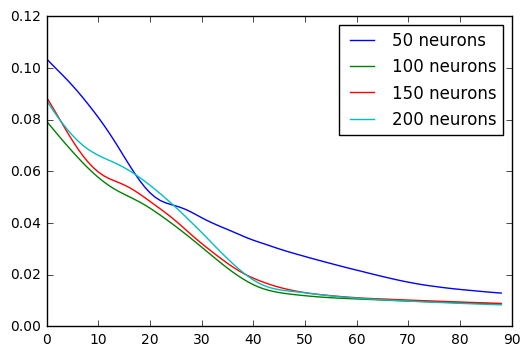

In [26]:
skip_start=10
plt.plot(train_50[skip_start:], label="50 neurons")
plt.plot(train_100[skip_start:], label="100 neurons")
plt.plot(train_150[skip_start:], label="150 neurons")
plt.plot(train_200[skip_start:], label="200 neurons")
plt.legend()
plt.show()

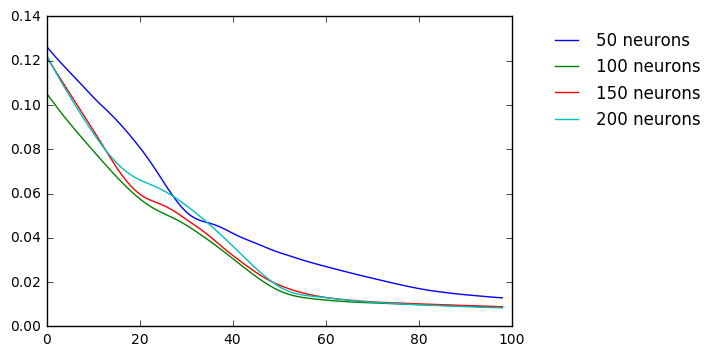

In [27]:
skip_start=0
plt.plot(train_50[skip_start:], label="50 neurons")
plt.plot(train_100[skip_start:], label="100 neurons")
plt.plot(train_150[skip_start:], label="150 neurons")
plt.plot(train_200[skip_start:], label="200 neurons")
plt.legend(frameon=False,bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("D:/Lab/Inverse design/3PC_layers_5NN_layers_40000exam.png",dpi=600)
plt.show()

# Var samples number

In [20]:
device = torch.device('cpu')
#torch.device('cpu')
#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

epochs=600
batch_size=20000

amount=20000
Spectrum_train=(refl[:amount])
Spectrum_train=torch.FloatTensor(Spectrum_train)
train_dataset=TensorDataset(Spectrum_train)

print("Starting model with 20K examples")

model_20K=Back_Net(2*points,N_layers,[50,100,100,100,100,100])
model_20K, train_20K, test_20K =train(model_20K, device, epochs, train_dataset, test_dataset, batch_size, points)

amount=40000
Spectrum_train=(refl[:amount])
Spectrum_train=torch.FloatTensor(Spectrum_train)
train_dataset=TensorDataset(Spectrum_train)
print("Starting model with 40K examples")

model_40K=Back_Net(2*points,N_layers,[50,100,100,100,100,100])
model_40K, train_40K, test_40K =train(model_40K, device, epochs, train_dataset, test_dataset, batch_size, points)

amount=80000
Spectrum_train=(refl[:amount])
Spectrum_train=torch.FloatTensor(Spectrum_train)
train_dataset=TensorDataset(Spectrum_train)
print("Starting model with 80K examples")

model_80K=Back_Net(2*points,N_layers,[50,100,100,100,100,100])
model_80K, train_80K, test_80K =train(model_80K, device, epochs, train_dataset, test_dataset, batch_size, points)

amount=200000
Spectrum_train=(refl[:amount])
Spectrum_train=torch.FloatTensor(Spectrum_train)
train_dataset=TensorDataset(Spectrum_train)
print("Starting model with 200K examples")

model_200K=Back_Net(2*points,N_layers,[50,100,100,100,100,100])
model_200K, train_200K, test_200K =train(model_200K, device, epochs, train_dataset, test_dataset, batch_size, points)

amount=400000
Spectrum_train=(refl)
Spectrum_train=torch.FloatTensor(Spectrum_train)
train_dataset=TensorDataset(Spectrum_train)
print("Starting model with 400K examples")

model_400K=Back_Net(2*points,N_layers,[50,100,100,100,100,100])
model_400K, train_400K, test_400K =train(model_20K, device, epochs, train_dataset, test_dataset, batch_size, points)

Starting model with 20K examples
Epoch number:10 Validation loss: 0.0549882, Training error: 0.0601909
Epoch number:20 Validation loss: 0.0143614, Training error: 0.0205729
Epoch number:30 Validation loss: 0.0085562, Training error: 0.0096049
Epoch number:40 Validation loss: 0.0066123, Training error: 0.0068657
Epoch number:50 Validation loss: 0.0051002, Training error: 0.0052911
Epoch number:60 Validation loss: 0.0039665, Training error: 0.0039925
Epoch number:70 Validation loss: 0.0035791, Training error: 0.0036561
Epoch number:80 Validation loss: 0.0032795, Training error: 0.0033199
Epoch number:90 Validation loss: 0.0030871, Training error: 0.0031196
Epoch number:100 Validation loss: 0.0029730, Training error: 0.0029804
Epoch number:110 Validation loss: 0.0028857, Training error: 0.0029018
Epoch number:120 Validation loss: 0.0028534, Training error: 0.0028546
Epoch number:130 Validation loss: 0.0028032, Training error: 0.0028070
Epoch number:140 Validation loss: 0.0027702, Training

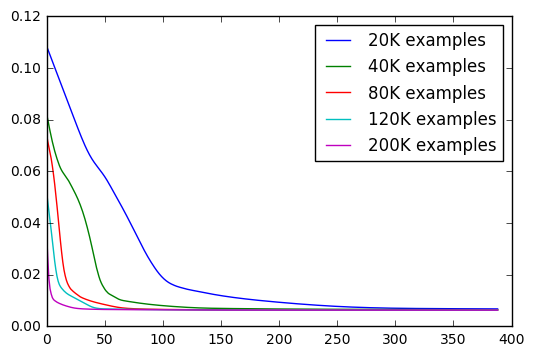

In [37]:
skip_start=10
plt.plot(train_20K[skip_start:], label="20K examples")
plt.plot(train_40K[skip_start:], label="40K examples")
plt.plot(train_80K[skip_start:], label="80K examples")
plt.plot(train_120K[skip_start:], label="120K examples")
plt.plot(train_200K[skip_start:], label="200K examples")
plt.legend()
plt.show()

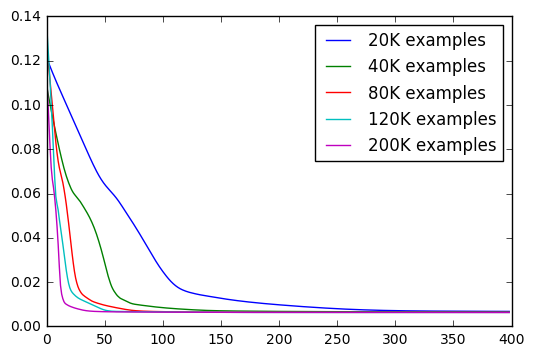

In [39]:
skip_start=0
plt.plot(train_20K[skip_start:], label="20K examples")
plt.plot(train_40K[skip_start:], label="40K examples")
plt.plot(train_80K[skip_start:], label="80K examples")
plt.plot(train_120K[skip_start:], label="120K examples")
plt.plot(train_200K[skip_start:], label="200K examples")
plt.legend()
plt.savefig("D:/Lab/Inverse design/3PC_layers_5NN_layers_last_layer_100.png",dpi=600)
plt.show()

# Var layers number

In [31]:
device =torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

epochs=250
#batch_size=20000

print("Starting model with 5 layers")
model_5=Back_Net(2*points,N_layers,[50,100,100,100,100])
model_5, train_5, test_5 =train(model_5, device, epochs, train_dataset, test_dataset, batch_size, points)

print("Starting model with 6 layers")
model_6=Back_Net(2*points,N_layers,[50,100,100,100,100,100])
model_6, train_6, test_6 =train(model_6, device, epochs, train_dataset, test_dataset, batch_size, points)

print("Starting model with 7 layers")
model_7=Back_Net(2*points,N_layers,[50,100,100,100,100,100,100])
model_7, train_7, test_7 =train(model_7, device, epochs, train_dataset, test_dataset, batch_size, points)

print("Starting model with 8 layers")
model_8=Back_Net(2*points,N_layers,[50,100,100,100,100,100,100,100])
model_8, train_8, test_8 =train(model_8, device, epochs, train_dataset, test_dataset, batch_size, points)

Starting model with 5 layers


TypeError: 'list' object is not callable

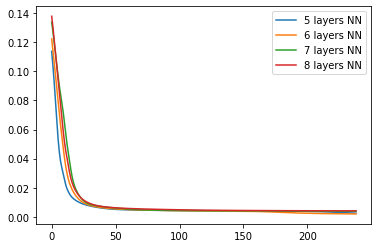

In [19]:
skip_start=10
plt.plot(train_5[skip_start:], label="5 layers NN")
plt.plot(train_6[skip_start:], label="6 layers NN")
plt.plot(train_7[skip_start:], label="7 layers NN")
plt.plot(train_8[skip_start:], label="8 layers NN")
plt.legend()
plt.show()

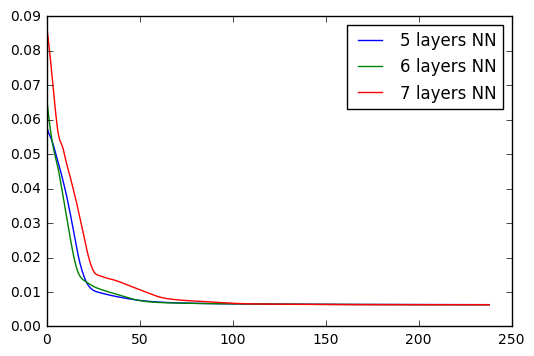

In [16]:
skip_start=10
plt.plot(train_5[skip_start:], label="5 layers NN")
plt.plot(train_6[skip_start:], label="6 layers NN")
plt.plot(train_7[skip_start:], label="7 layers NN")
plt.legend()
plt.savefig("D:/Lab/Inverse design/3PC_layers_last_layer_100.png",dpi=600)
plt.show()

# Single model

In [28]:
train_samples_amount=30000
Spectrum_train=torch.FloatTensor(refl_train[:train_samples_amount])
train_dataset=TensorDataset(Spectrum_train)

test_samples_amount=10000
Spectrum_test=torch.FloatTensor(refl_test[:test_samples_amount])
test_dataset=TensorDataset(Spectrum_test)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#wavevectors_pt=torch.tensor(wavevectors,device=device)
epochs=100
batch_size=10000

#model=Back_Net(2*points,N_layers,[100])
#model.weight_init()
model=Back_Net(2*points,N_layers,[300,300,300,300])
model,train_err,test_err=train(model, device, epochs, train_dataset, test_dataset, batch_size, points)

Epoch number:10 Validation loss: 0.0591548, Training error: 0.0658624
Epoch number:20 Validation loss: 0.0650809, Training error: 0.0695118
Epoch number:30 Validation loss: 0.0322391, Training error: 0.0323052
Epoch number:40 Validation loss: 0.0234532, Training error: 0.0240629
Epoch number:50 Validation loss: 0.0202080, Training error: 0.0208521
Epoch number:60 Validation loss: 0.0176819, Training error: 0.0184940
Epoch number:70 Validation loss: 0.0159200, Training error: 0.0144706
Epoch number:80 Validation loss: 0.0136281, Training error: 0.0123354
Epoch number:90 Validation loss: 0.0109265, Training error: 0.0113452


In [30]:
model

Back_Net(
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): Linear(in_features=100, out_features=12, bias=True)
  )
)

# Model check

In [171]:
angles=np.linspace(angle_min,angle_max,points)
thick=model_t(Spectrum_test)
thick=thick.detach().numpy()*d_max
true_val=Spectrum_test.numpy()

N_all=create_N_for_all_angles(training_structure[:,0],angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=numpy_create_tm_all_angles(N_all)
phase=numpy_phase_all_angles(thick,N_all,2*np.pi/780)
total_matrix=numpy_R_for_all_angles(phase,transfer)
if training_type=='real+imag':
    r=np.zeros((Spectrum_test.size(0),2*points),dtype=float)
    r[:,:points]=np.real(total_matrix)
    r[:,points:]=np.imag(total_matrix)
else:
    r=np.zeros((Spectrum_test.size(0),points),dtype=float)
    r[:,:points]=np.abs(total_matrix)

Thickness from NN:  [287.71487  292.5381   161.07391   97.45689  165.42589  290.17783
 270.09375   80.101814 240.95645   96.317924 160.64613   95.830505]
Thickness for spectrum generation:  [117  12  32 272 208 267 281 268 231 339 207 110]


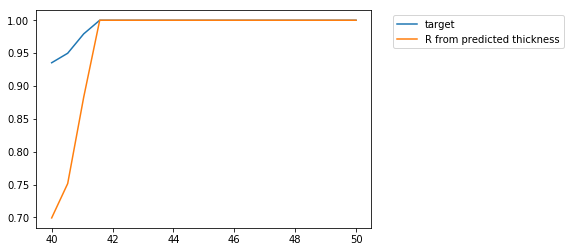

In [173]:
number=50
print("Thickness from NN: ",thick[number])
print("Thickness for spectrum generation: ",thicknes_test.real[number])
plt.plot(angles, np.sqrt(true_val[number,:points]**2+true_val[number,points:]**2), label="target")
plt.plot(angles, np.sqrt(r[number,:points]**2+r[number,points:]**2), label="R from predicted thickness")
#plt.plot(angles,true_val[number],label="target")
#plt.plot(angles,r[number],label="predicted")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Thickness from NN:  [283.62122  289.71472  183.16302   96.37853  240.68181   80.876915
 236.66434  294.9427   158.28479   96.56256  150.18645   96.64247 ]
Thickness for spectrum generation:  [306 349 315 295 166  81 331 169  14 329  24 209]


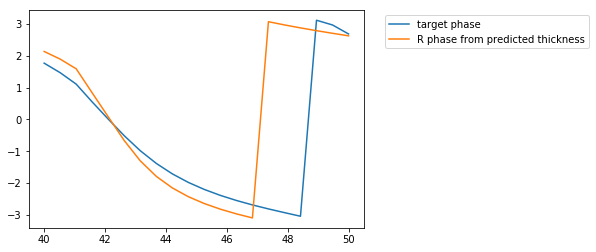

In [174]:
number=5
print("Thickness from NN: ",thick[number])
print("Thickness for spectrum generation: ",thicknes_test.real[number])
#plt.plot(angles, pred_val.detach().numpy(), label="predicted")
#plt.plot(angles, np.sqrt(true_val[:points]**2+true_val[points:]**2), label="target")
plt.plot(angles, np.arctan2(true_val[number,points:],true_val[number,:points]), label="target phase")
plt.plot(angles, np.arctan2(r[number,points:],r[number,:points]), label="R phase from predicted thickness")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Save model and results

In [29]:
t=np.asarray([[val.cpu().numpy() for val in test_err],[val.detach().cpu().numpy() for val in train_err]])
(t.T).shape

(99, 2)

In [40]:
header=f"structure:\n{n_structure}\n angle range:{angle_min} -\
{angle_max}\n number of training samples={Spectrum_train.shape}\n number of test samples\
={Spectrum_test.shape}\n batch size:{batch_size}\n test error, train error"
filename=f'/Users/kirillsafronov/Documents/Python/Lab/NN_for_PC/trained_models/angles/PC_{N_layers}\
layers_{Spectrum_train.shape[0]}samples_{angle_min}-{angle_max}_{t.min():.5}'
np.savetxt(filename+'.txt',t.T,
           header=header)

In [41]:
torch.save(model, filename+'.pth')

# Load model

In [181]:
model_t=torch.load("trained_models/PC12_layers_from_glass_300K_50-60.pth",map_location=torch.device('cpu'))
model_t

Back_Net(
  (layers): ModuleList(
    (0): Linear(in_features=40, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=100, bias=True)
    (6): Linear(in_features=100, out_features=12, bias=True)
  )
)

In [198]:
loss=nn.MSELoss()
N_all=create_N_for_all_angles(training_structure[:,0],angle_start=angle_min, angle_stop=angle_max, points=points)
transfer=create_transfer_matrix_all_angles(N_all)
N_all=torch.FloatTensor(np.real(N_all))
with torch.no_grad():
    model_t.eval()
    test_preds = model_t.forward(Spectrum_test)
    result=loss(R_for_batch(test_preds*d_max,N_all,transfer, wl=780, points=points), Spectrum_test)

In [199]:
result

tensor(0.0257)

# Differentiator

In [163]:
angle_center=55
angle_min=50
angle_max=60
angles=np.linspace(angle_min,angle_max,points)
alpha=0.2/sin((angle_max-angle_center)*np.pi/180)
diff_transfer_matrix=alpha*1j*np.sin((angles-angle_center)*np.pi/180)
refl_diff=np.zeros((2*points),dtype=float)
refl_diff[:points]=np.real(diff_transfer_matrix)
refl_diff[points:]=np.imag(diff_transfer_matrix)

#refl_diff=np.zeros((points),dtype=float)

In [164]:
diff_spectrum=torch.tensor(refl_diff[None,:],device=torch.device('cpu'),dtype=torch.float32)
thick=model_t(diff_spectrum)
thick=thick.detach().numpy()*d_max

N_all=create_N_for_all_angles(training_structure[:,0],angle_start=angle_min, angle_stop=angle_max,points=points)
transfer=numpy_create_tm_all_angles(N_all)
phase=numpy_phase_all_angles(thick,N_all,2*np.pi/780)
total_matrix=numpy_R_for_all_angles(phase,transfer)

r=np.zeros((2*points),dtype=float)
r[:points]=np.real(total_matrix)
r[points:]=np.imag(total_matrix)

#r=np.abs(total_matrix)

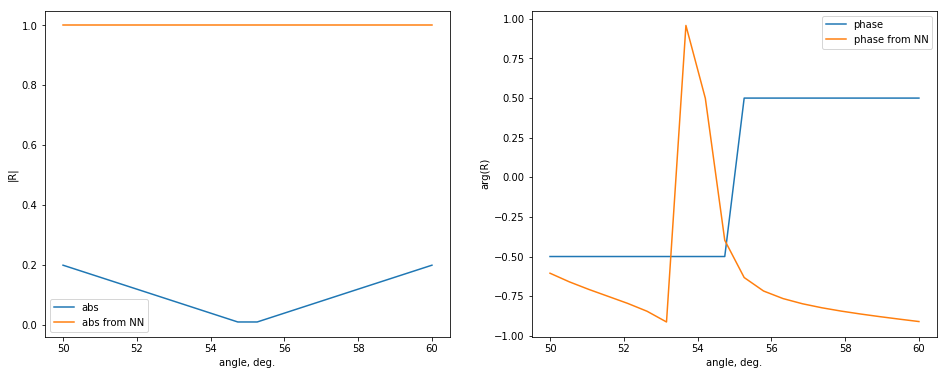

In [165]:
fig=plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(angles, np.sqrt(refl_diff[:points]**2+refl_diff[points:]**2), label="abs")
plt.plot(angles, np.sqrt(r[:points]**2+r[points:]**2), label="abs from NN")
plt.xlabel("angle, deg.")
plt.ylabel("|R|")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
plt.subplot(1,2,2)
plt.plot(angles, np.arctan2(refl_diff[points:],refl_diff[:points])/np.pi, label="phase")
plt.plot(angles, np.arctan2(r[points:],r[:points])/np.pi, label="phase from NN")
plt.xlabel("angle, deg.")
plt.ylabel("arg(R)")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend()
#plt.savefig("D:/Lab/Inverse design/model_15PC_6NN_5e5_differentiator_1.png", dpi=600, bbox_inches='tight')
plt.show()

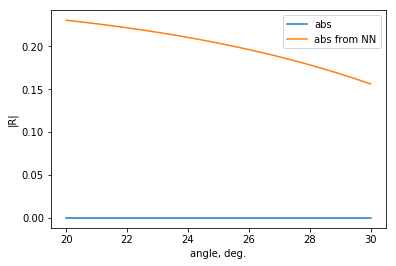

In [90]:
plt.plot(angles, (refl_diff), label="abs")
plt.plot(angles, r[0], label="abs from NN")
plt.xlabel("angle, deg.")
plt.ylabel("|R|")
plt.legend()
#plt.savefig("D:/Lab/Inverse design/model_15PC_6NN_5e5_differentiator_1.png", dpi=600, bbox_inches='tight')
plt.show()

# Plot for final results

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [ ]:
font=15
number=39100
print("Thickness from NN: ",thick[number])
print("Thickness for spectrum generation: ",thicknes_test.real[number])
fig=plt.figure(figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(angles, np.sqrt(true_val[number,:points]**2+true_val[number,points:]**2), label="Target")
plt.plot(angles, np.sqrt(r[number,:points]**2+r[number,points:]**2), label="Designed")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(frameon=False, fontsize=17)
plt.ylim(bottom=0,top=1)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
ax=plt.gca()
ax.tick_params(which='major',axis='both', direction='out', width=1.5,length=5)
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor',axis='both', direction='out', width=1.1,length=3)

plt.subplot(1,2,2)
plt.plot(angles, np.arctan2(true_val[number,points:],true_val[number,:points])/np.pi, label="Target")
plt.plot(angles, np.arctan2(r[number,points:],r[number,:points])/np.pi, label="Designed")
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(bottom=-1,top=1)
plt.legend(frameon=False, fontsize=17)
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
ax=plt.gca()
ax.tick_params(which='major',axis='both', direction='out', width=1.5,length=5)
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(1.5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor',axis='both', direction='out', width=1.1,length=3)

#plt.savefig("D:/Lab/tex/META 2020/fig.png", dpi=700)
plt.show()

In [4]:
n_samples=400000

Sample_n_per_cycle=40000
sample_numbers=np.arange(0,stop=n_samples, step=Sample_n_per_cycle)

In [5]:
sample_numbers

array([     0,  40000,  80000, 120000, 160000, 200000, 240000, 280000,
       320000, 360000])